<a href="https://colab.research.google.com/github/data-better/forecasting_class/blob/main/R_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. 구글 Colab

* 구글 id가 있어야 이용 가능, 구글 drive 이용
* 텍스트와 코드로 구성 
  - 텍스트 작성 : 마크다운
  - 코드 수행 : Crtl+Enter, Shift+Enter, Alt+Enter 
* 크롬 브라우저에서 Python과 R을 실행 : R은 임시
  - 설치 필요하지 않음
  - GPU 무료 액세스
* Pyhon 기반 : https://colab.research.google.com/
* R : https://colab.research.google.com/notebook#create=true&language=r

In [1]:
library()

## 1. 이용할 패키지 불러오기



 * 예측관련 패키지 : forecast, mFilter
 * 시간이 좀 걸립니다.

In [2]:
install.packages(c('forecast', 'mFilter'))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’




In [14]:
library(forecast)
library(mFilter)

## 1. 데이터 읽기
  * KOSIS 또는 ECOS에서 데이터를 csv 형태로 내려받은 후 설명한 내용을 제거하고, 셀형식을 "," 없는 숫자로 전환하여 직사각형 형태로 저장
    - 여기서는 1970년- 2020년 분기 제조업 GDP, 서비스업 GDP, GDP 입니다.
    - github에 이미 정리 : https://github.com/data-better/forecasting_class/tree/main/data  
  * magrittr 패키지를 이용하면 %>% 의 파이프를 쓸 수 있습니다.
    - head(log(gdp_ts)) 와 gdp_ts %>% log() %>% head()는 동일한 명령어

In [9]:
# GITHUB의 data 폴더의 csv를 지정하여 읽어옴

#  제조업 GDP, 서비스업 GDP, GDP  원계열
url_o = "https://raw.githubusercontent.com/data-better/forecasting_class/main/data/gdp_21.csv"
gdp_ts = url_o %>% read.csv() %>% ts(start=1970, frequency=4)
gdp_ts %>% head()

gdp_m  gdp_s   gdp    
1970 Q1 1225.4  9632.0 15052.7
1970 Q2 1453.9 10191.9 18205.6
1970 Q3 1521.6 10494.1 17405.9
1970 Q4 1787.7 10444.1 21438.5
1971 Q1 1526.1 11051.6 16974.8
1971 Q2 1769.2 11564.6 20607.8

In [10]:
#  제조업 GDP, 서비스업 GDP, GDP  계절조정계열
url_sa = "https://raw.githubusercontent.com/data-better/forecasting_class/main/data/gdp_sa_21.csv"
gdp_sa_ts = url_sa %>% read.csv() %>% ts(start=1970, frequency=4)
gdp_sa_ts %>% head()

gdp_m_sa gdp_s_sa gdp_sa 
1970 Q1 1358.9    9649.3  17109.7
1970 Q2 1440.9   10023.7  17797.7
1970 Q3 1503.6   10257.6  17907.8
1970 Q4 1685.2   10831.6  19287.5
1971 Q1 1672.8   11037.4  19395.7
1971 Q2 1747.5   11369.4  20027.5

In [15]:
# 그래프 크기 조정 옵션 등
options(warn=-1,repr.plot.width = 10, repr.plot.height = 6)

In [16]:
# 변수 선택
gdp = gdp_ts[,3]/1000
gdp_sa = gdp_sa_ts[,3]/1000

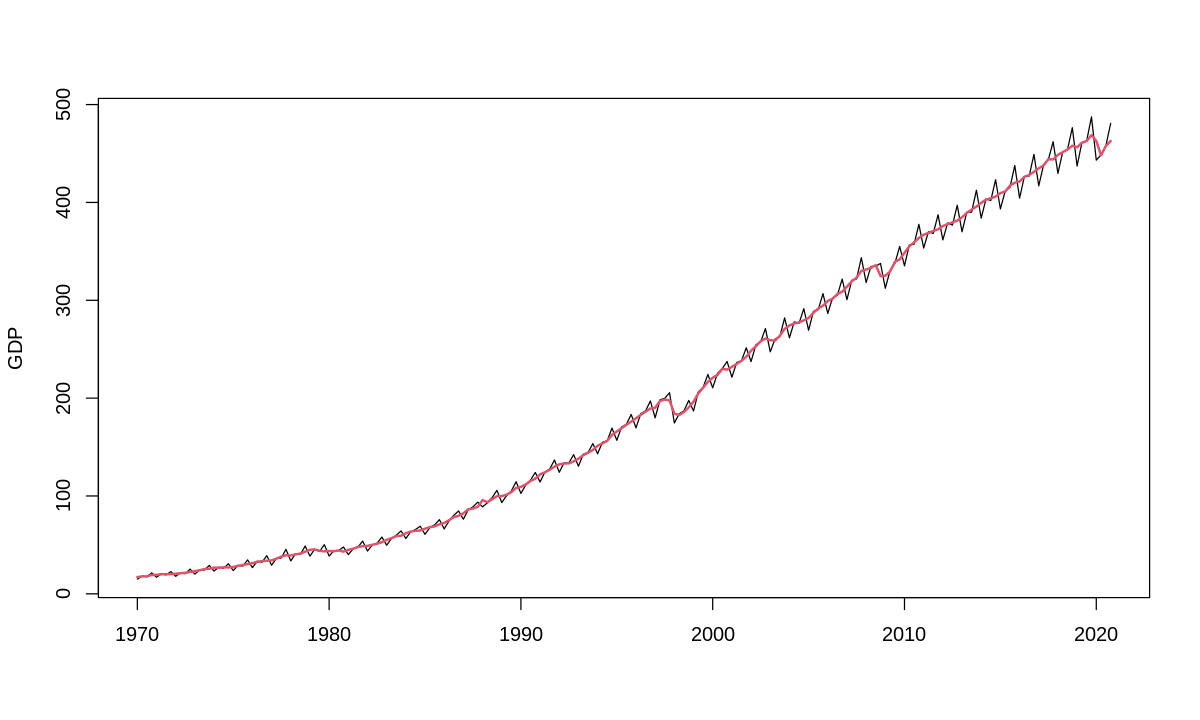

In [17]:
plot(gdp, xlab="", ylab="GDP" )
 lines(gdp_sa, col=2, lwd=2 )

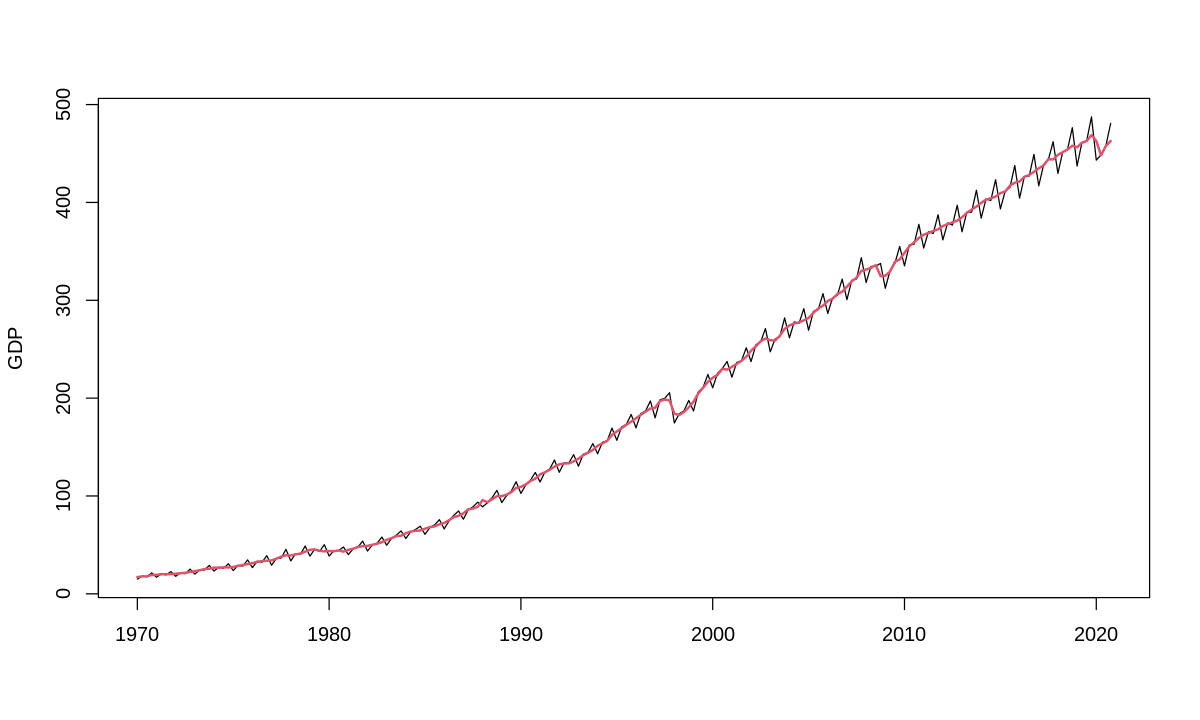

In [18]:
gdp %>% plot(xlab="", ylab="GDP" )
  gdp_sa %>% lines(col=2, lwd=2 )

## 3. 시계열의 탐색
   * 시계열도표로 패턴 파악
   * 스펙트럴 분석
   * 표본자기상관계수, 표본 부분자기상관계수

### (1) 시계열도표

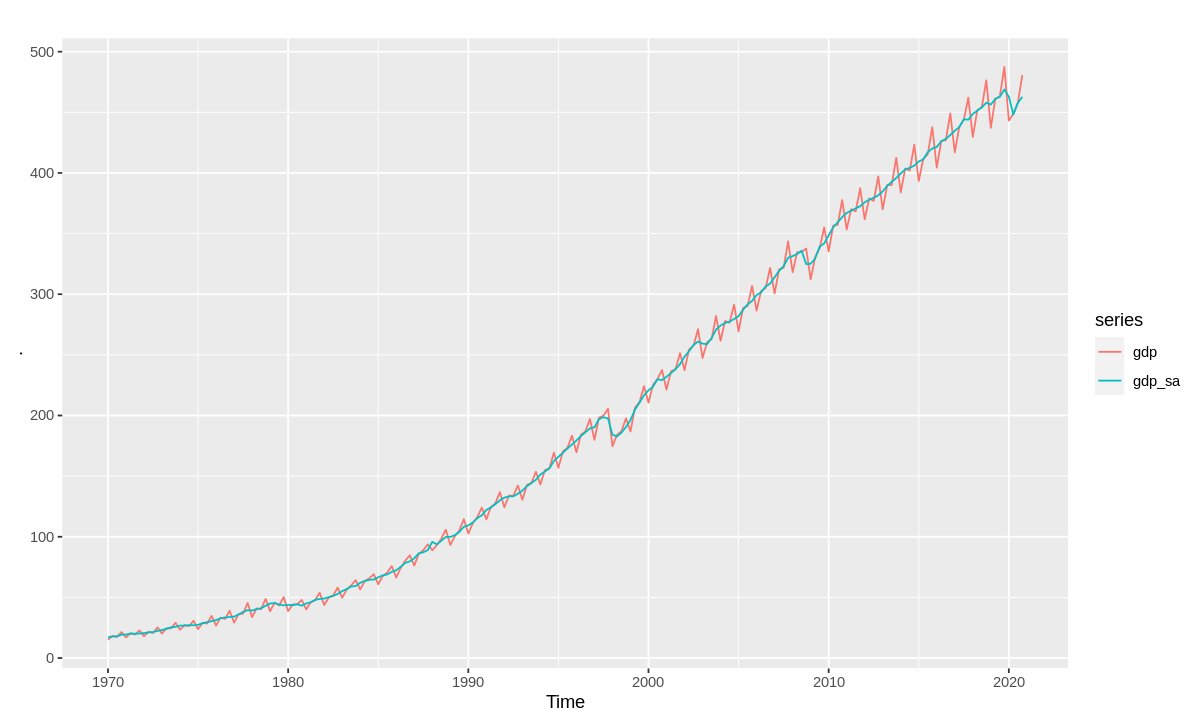

In [19]:
cbind(gdp, gdp_sa) %>% autoplot()

 ### (2) 전기증감률과 로그차분의 비교

Qtr1         Qtr2         Qtr3         Qtr4        
2018 0.0056445661 0.0018865838 0.0016587550 0.0037234634
2019 0.0005782712 0.0051079212 0.0007030732 0.0085273831
2020 0.0082846598 0.0508049734 0.0224957770 0.0058808713

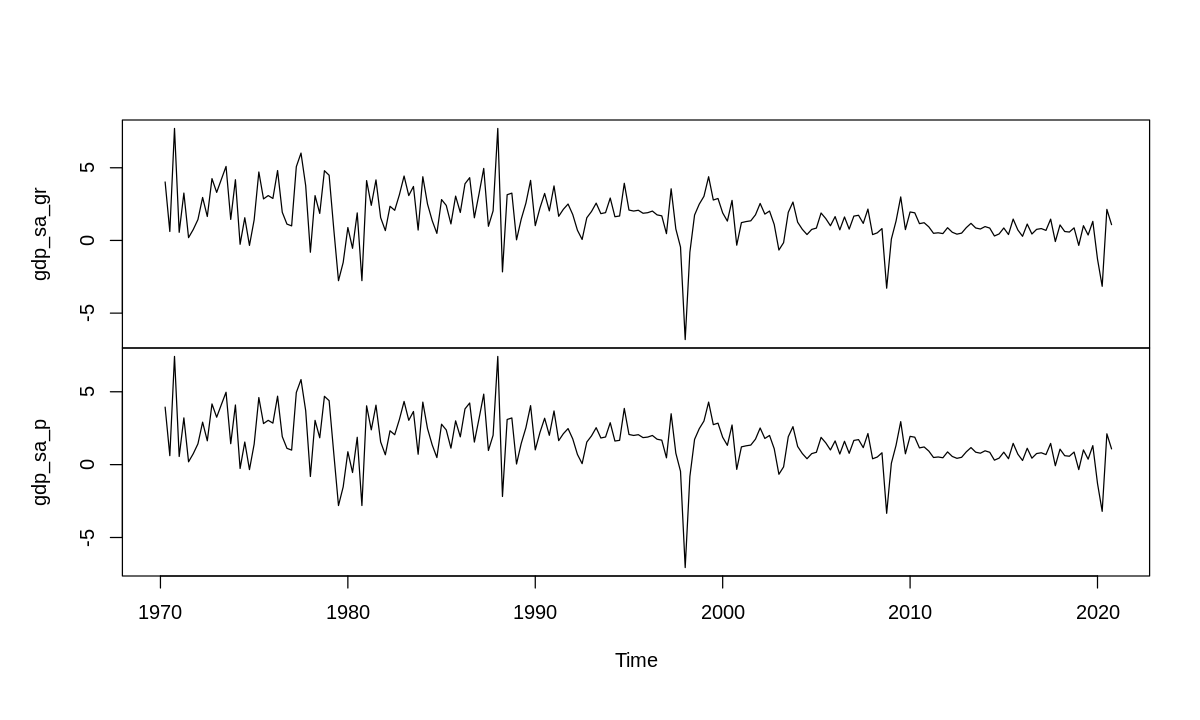

In [20]:
gdp_sa_gr = ts(c(NA, (gdp_sa-lag(gdp_sa,-1))/lag(gdp_sa,-1)*100),  start=1970, frequency=4)
gdp_sa_p  = diff(log(gdp_sa))*100
plot(cbind(gdp_sa_gr, gdp_sa_p), main="")
gdp_sa_gr - gdp_sa_p %>% tail(12)

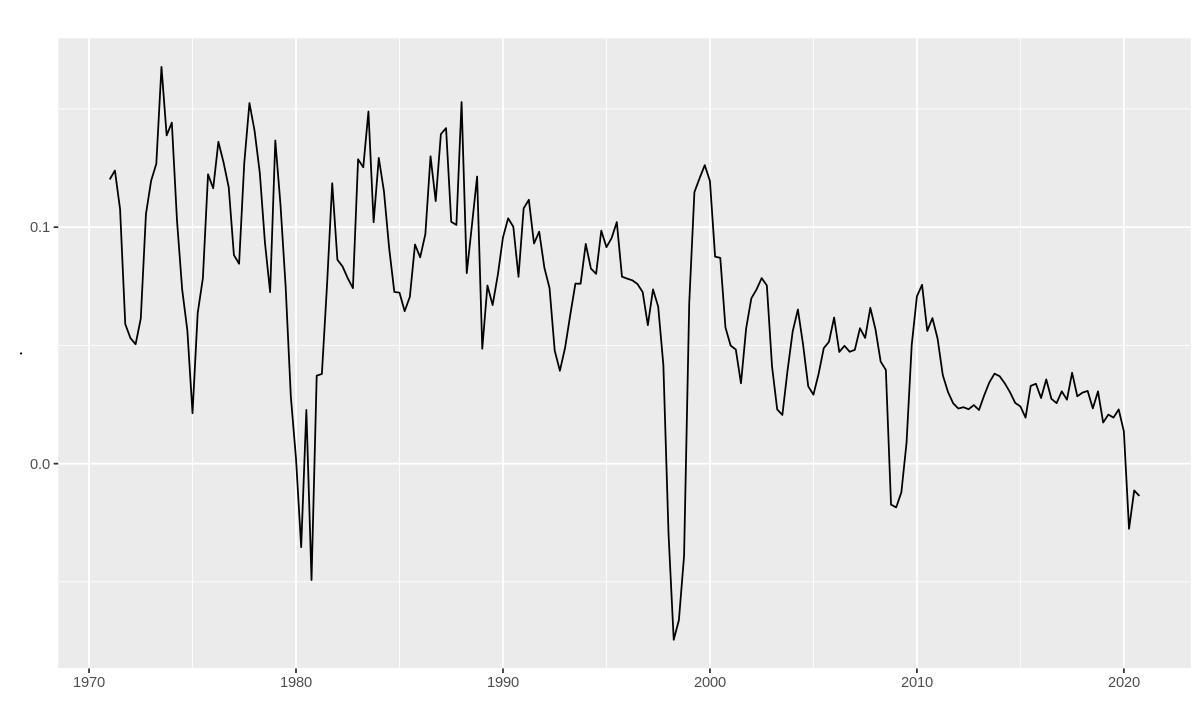

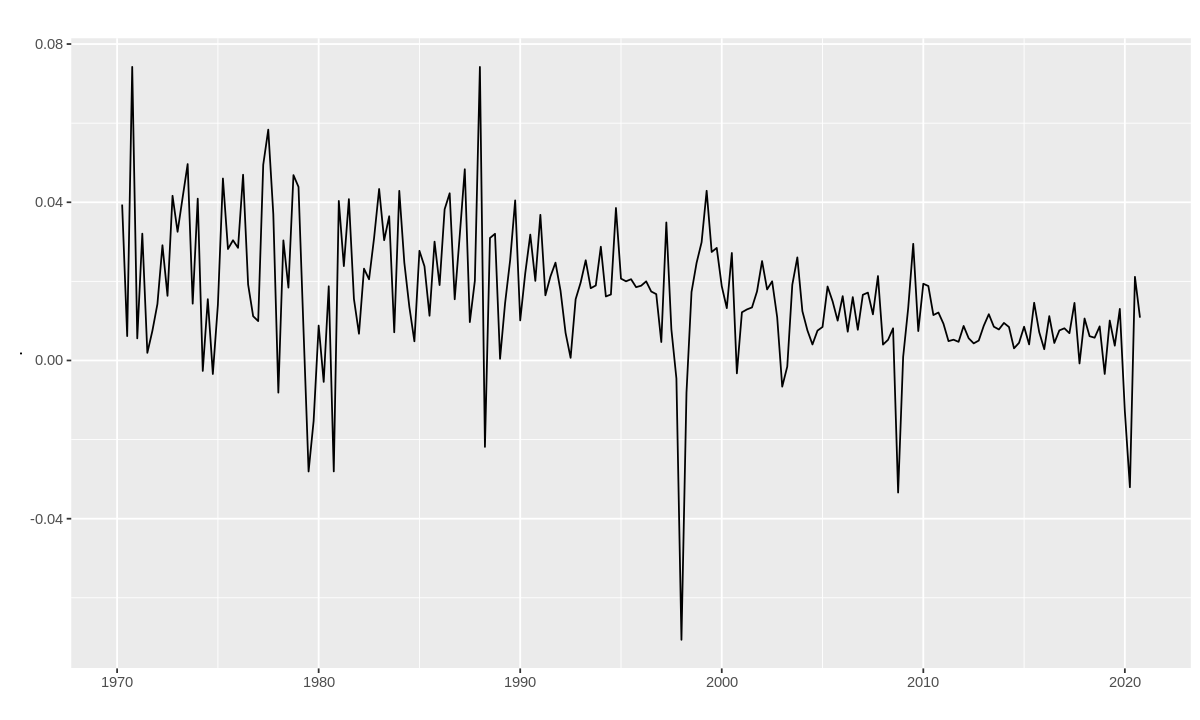

In [21]:
gdp %>% log() %>% diff(lag=4) %>% autoplot(xlab="")
gdp_sa %>% log() %>% diff() %>% autoplot(xlab="")

### (3) 스펙트럴 분석
* 주기적 시계열의 분석

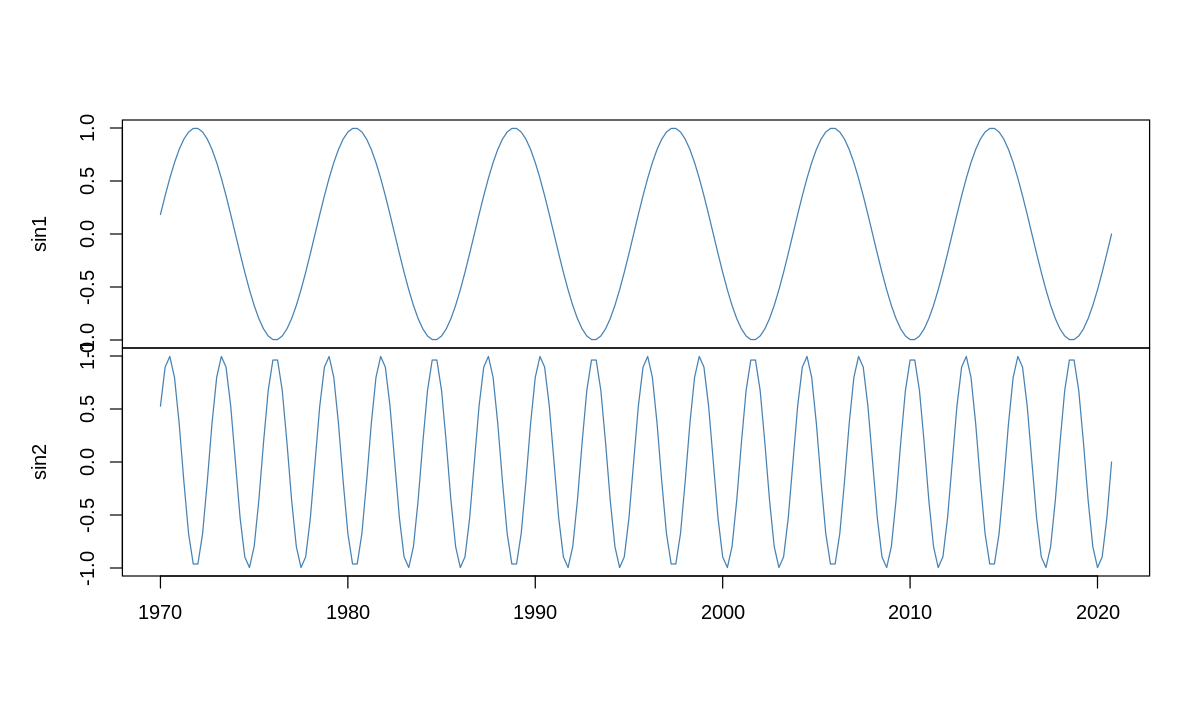

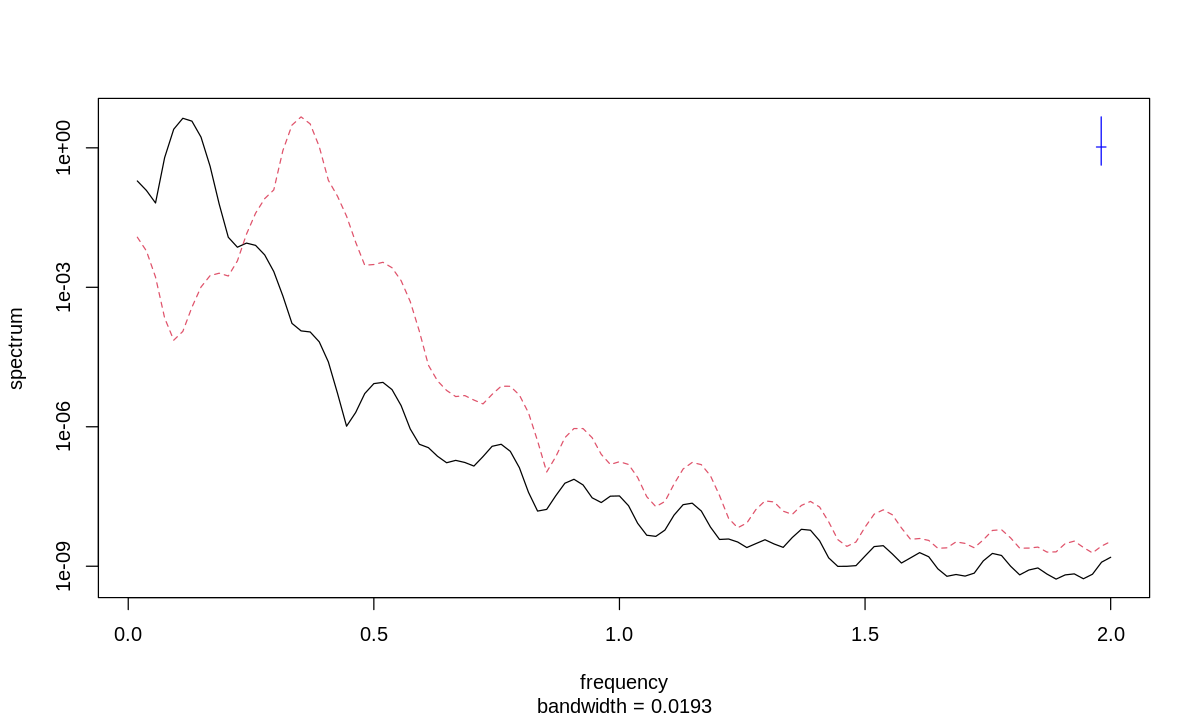

In [22]:
nn = gdp %>% length()
sin1 = sin(1:nn/nn*12*pi) %>% ts(start=1970, frequency=4)
sin2 = sin(1:nn/nn*36*pi) %>% ts(start=1970, frequency=4)
plot(cbind(sin1, sin2), main="", xlab="", ylab="", col="steelblue")
spectrum(cbind(sin1, sin2), spans=c(3,3), main="", col=1:2)

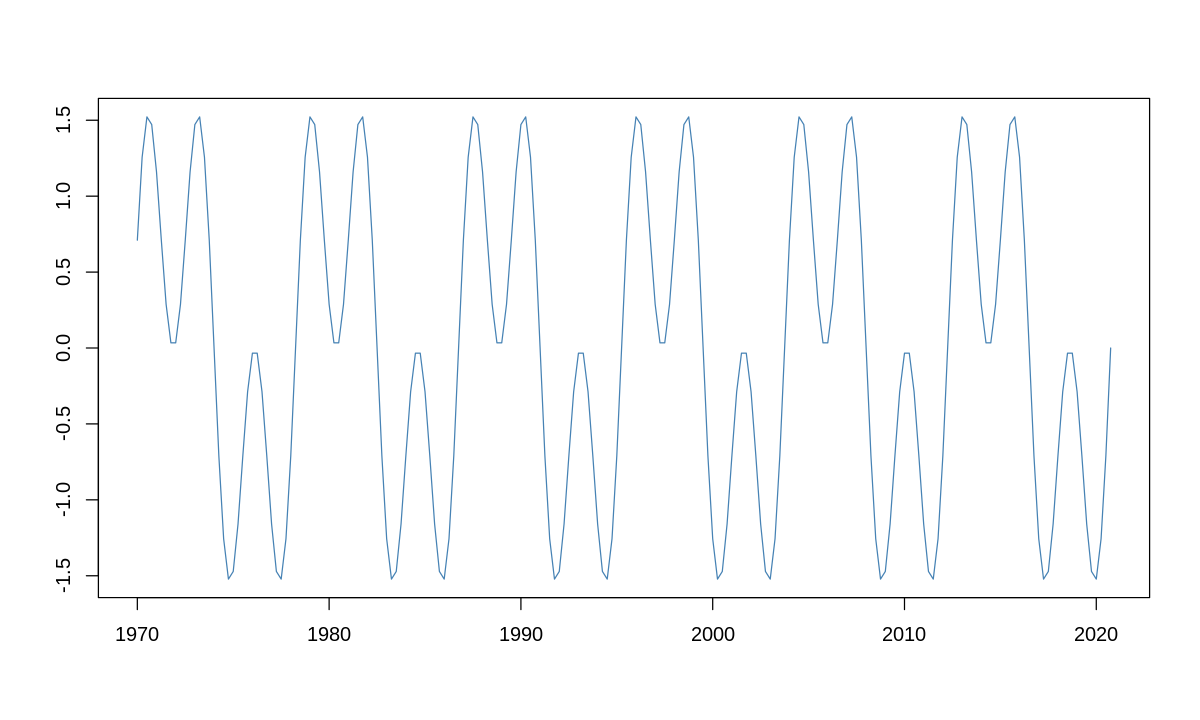

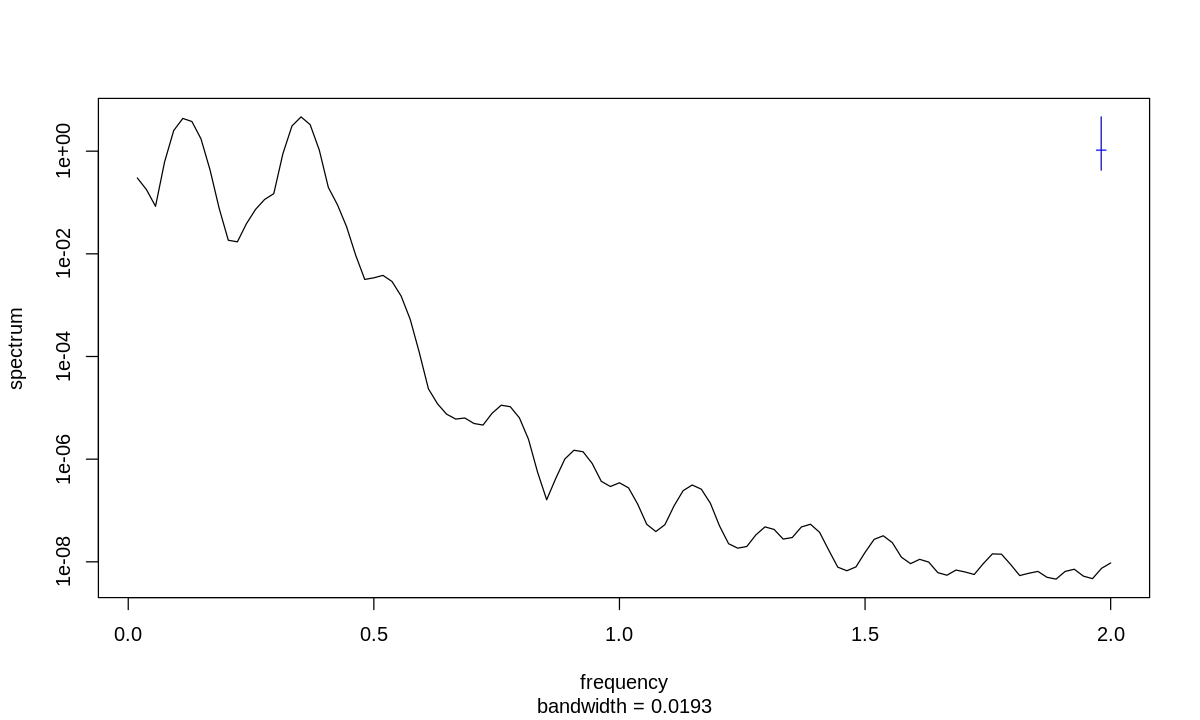

In [23]:
plot(sin1+sin2, main="", xlab="", ylab="", col="steelblue")
spectrum(sin1+sin2, spans=c(3,3), main="", col=1)

### (4) GDP와 계절조정 GDP의 스펙트럼
 * 원계열은 계절 빈도수에서 큰 값을 보임

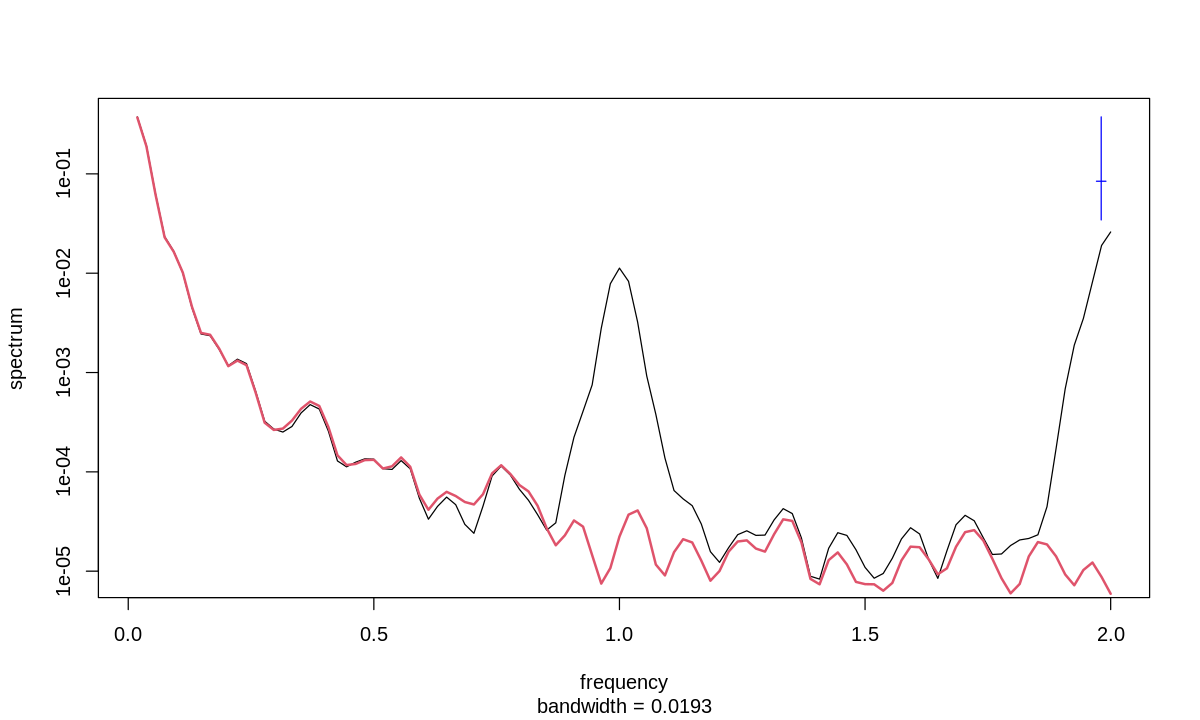

In [24]:
gdp %>% log() %>% spectrum(spans=c(3,3), main="") 
gdp_sa %>% log() %>% spectrum(spans=c(3,3), add=TRUE, col=2, lwd=2) 

### (5) 표본자기상관계수와 표본부분자기상관계수
* 원계열

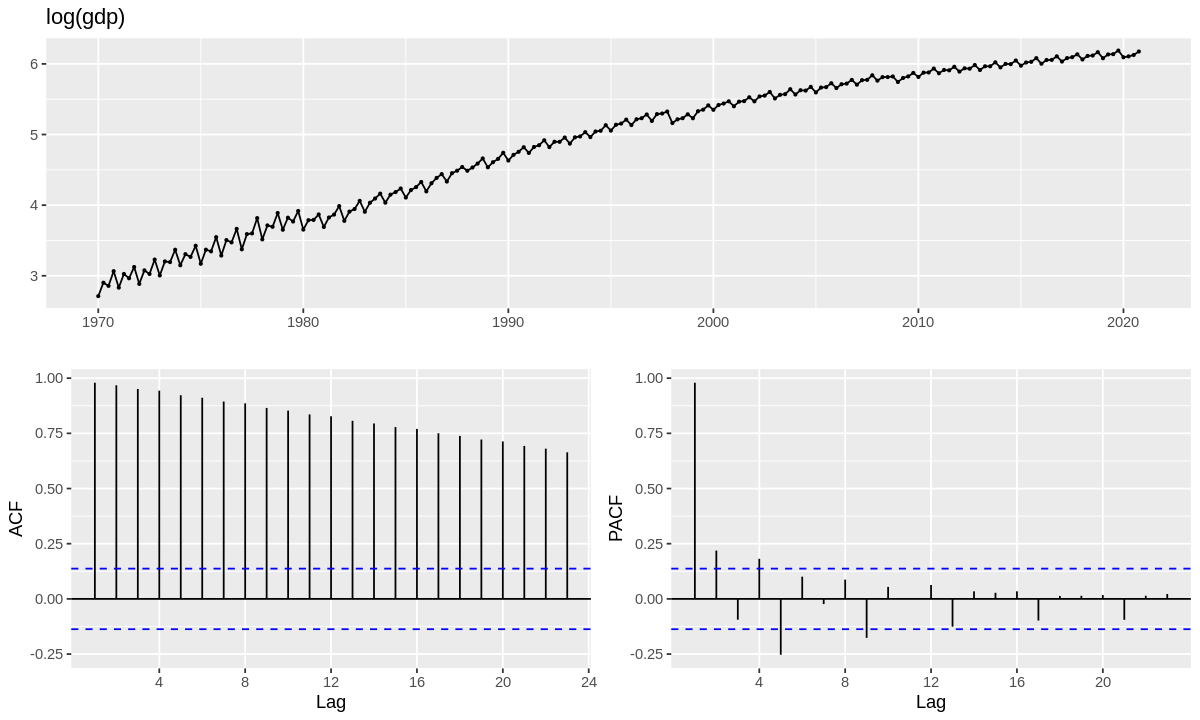

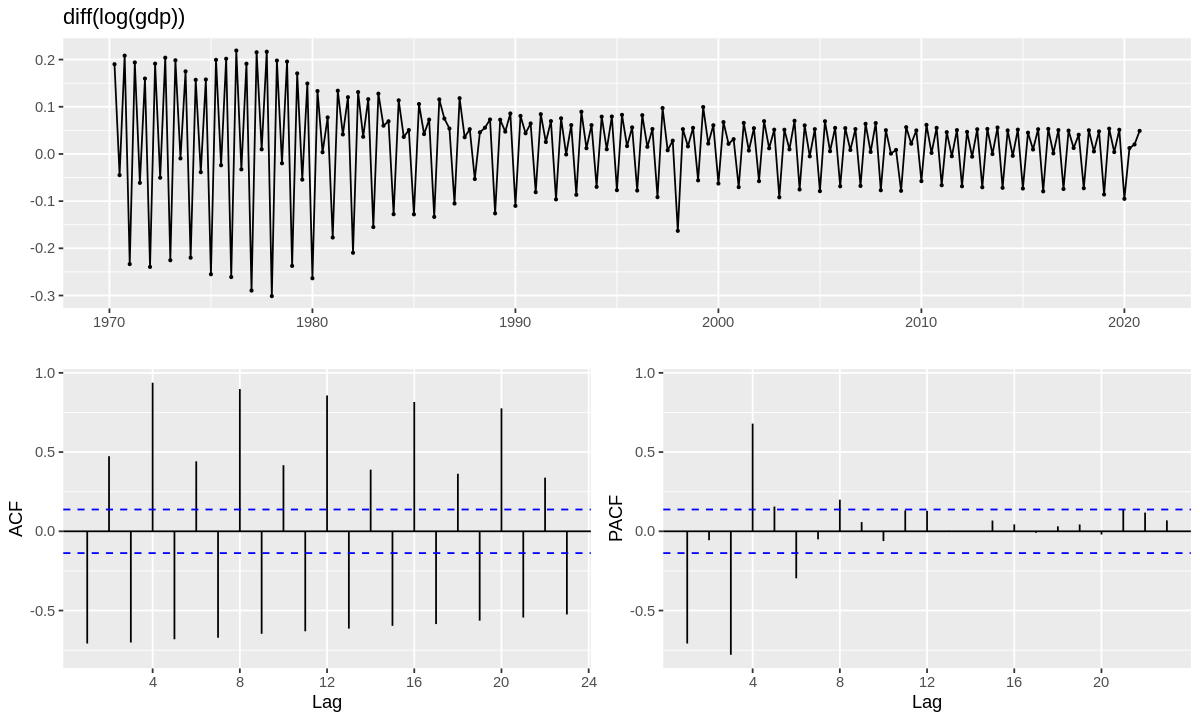

In [25]:
gdp %>% log() %>% ggtsdisplay(main="log(gdp)")
gdp %>% log() %>% diff() %>% ggtsdisplay(main="diff(log(gdp))") 

* 계절조정계열

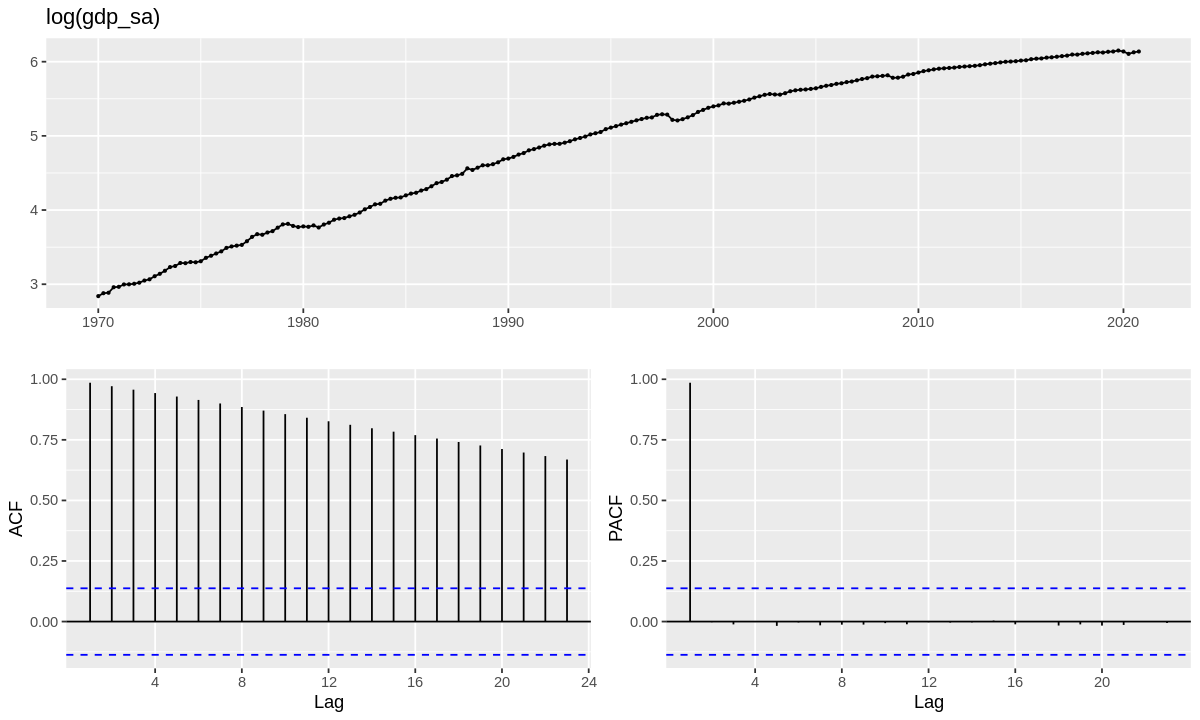

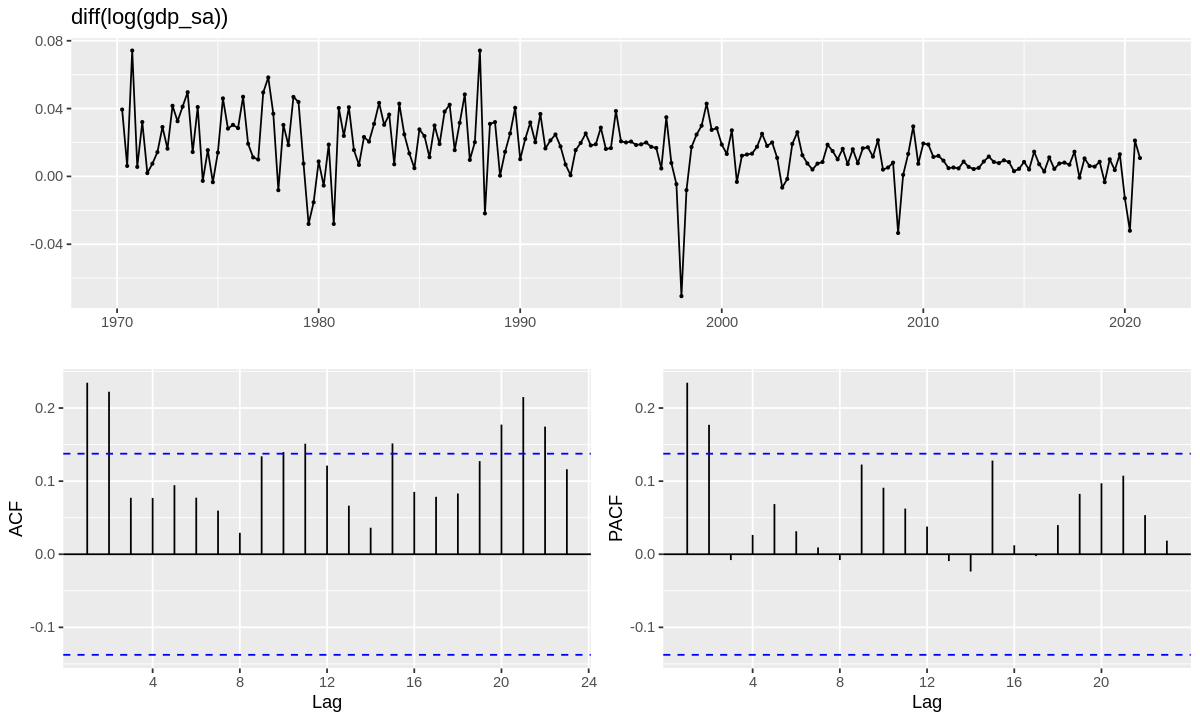

In [26]:
gdp_sa %>% log() %>% ggtsdisplay(main="log(gdp_sa)")
gdp_sa %>% log() %>% diff() %>% ggtsdisplay(main="diff(log(gdp_sa))")

## 5. ARIMA모형

* 시뮬레이션된 데이터와 ACF와 PACF 모습 정리

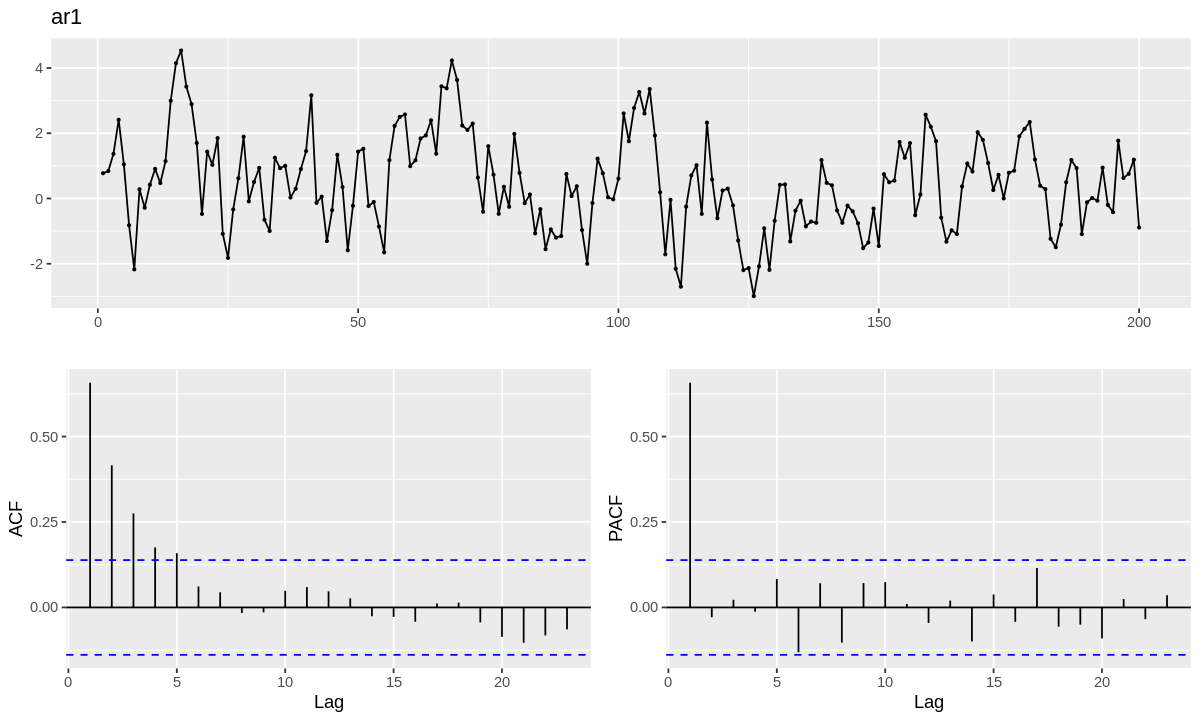

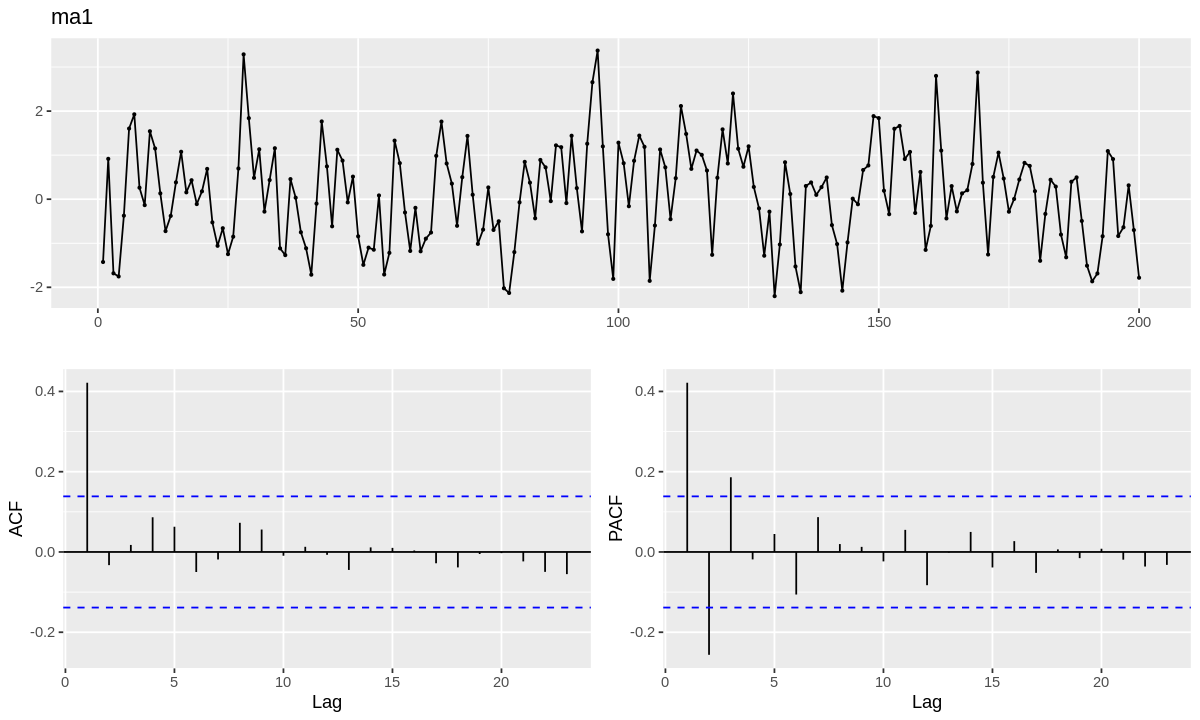

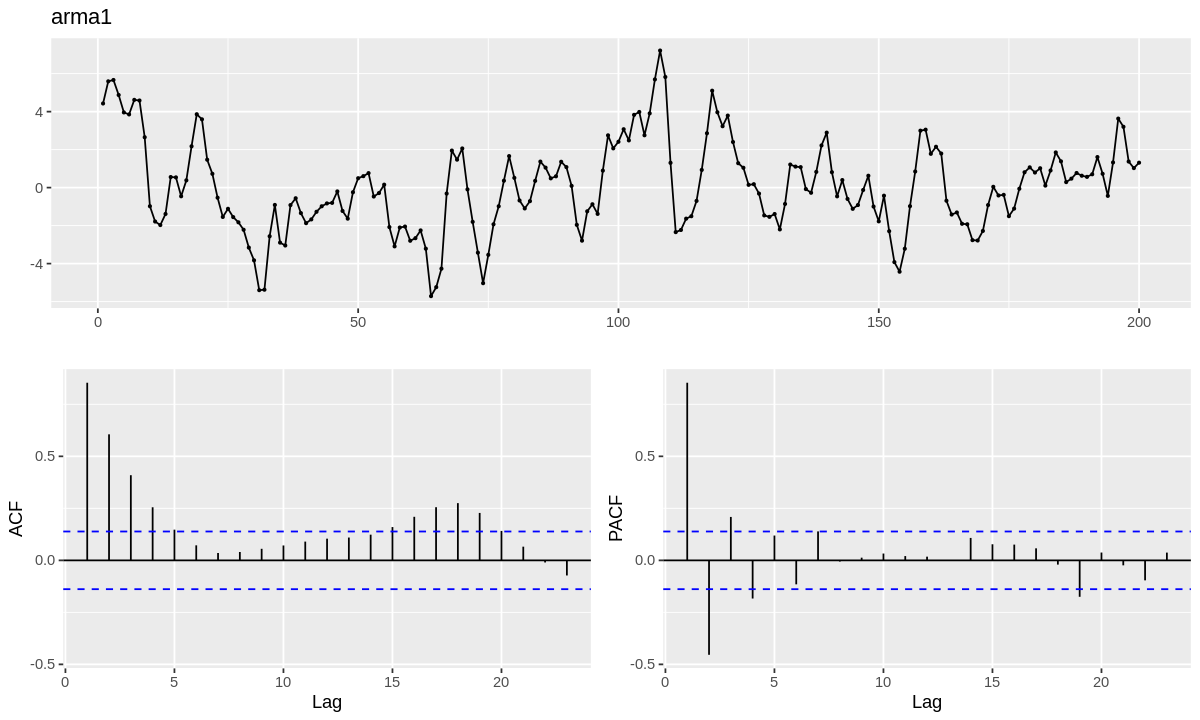

In [27]:
set.seed(12345)
ar1=arima.sim(list(order = c(1,0,0), ar=0.7), n = 200)
ma1=arima.sim(list(order = c(0,0,1), ma=0.7), n = 200)
arma1=arima.sim(list(order = c(1,0,1), ar=0.7, ma=0.7), n = 200)
ar1 %>%  ggtsdisplay(main="ar1")
ma1 %>%  ggtsdisplay(main="ma1")
arma1 %>%  ggtsdisplay(main="arma1")

* ARIMA 모형의 추정

In [28]:
ar1=arima.sim(list(order = c(1,0,1), ar=0.7, ma=0.7), n = 200)
ar1_train =ar1[1:160]
ar1_test  =ar1[161:200]

arima_1 = arima(ar1_train, order=c(1,0,0))
arima_2 = arima(ar1_train, order=c(0,0,1))
arima_3 = arima(ar1_train, order=c(1,0,1))
arima_4 = arima(ar1_train, order=c(2,0,0))
arima_5 = auto.arima(ar1_train)

In [29]:
arima_1
arima_2
arima_3
arima_4
arima_5


Call:
arima(x = ar1_train, order = c(1, 0, 0))

Coefficients:
         ar1  intercept
      0.8358     0.6174
s.e.  0.0424     0.5603

sigma^2 estimated as 1.44:  log likelihood = -256.79,  aic = 519.59


Call:
arima(x = ar1_train, order = c(0, 0, 1))

Coefficients:
         ma1  intercept
      0.9306     0.6636
s.e.  0.0365     0.1976

sigma^2 estimated as 1.687:  log likelihood = -269.86,  aic = 545.71


Call:
arima(x = ar1_train, order = c(1, 0, 1))

Coefficients:
         ar1     ma1  intercept
      0.6877  0.7091     0.6527
s.e.  0.0611  0.0660     0.4291

sigma^2 estimated as 1.015:  log likelihood = -229.33,  aic = 466.65


Call:
arima(x = ar1_train, order = c(2, 0, 0))

Coefficients:
         ar1      ar2  intercept
      1.2161  -0.4524     0.6580
s.e.  0.0699   0.0699     0.3543

sigma^2 estimated as 1.14:  log likelihood = -238.32,  aic = 484.65

Series: ar1_train 
ARIMA(1,1,2) 

Coefficients:
         ar1      ma1      ma2
      0.6635  -0.2625  -0.6950
s.e.  0.0702   0.0700   0.0649

sigma^2 estimated as 1.046:  log likelihood=-228.65
AIC=465.3   AICc=465.56   BIC=477.58

In [30]:
f1 = predict(arima_1, 40)
f2 = predict(arima_2, 40)
f3 = predict(arima_3, 40)
f4 = predict(arima_4, 40)
f5 = predict(arima_5, 40)

In [31]:
install.packages("DMwR")
library(DMwR)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘gtools’, ‘caTools’, ‘gplots’, ‘abind’, ‘ROCR’


Loading required package: lattice

Loading required package: grid



In [32]:
acc_1=regr.eval(ar1_test, f1$pred)
acc_2=regr.eval(ar1_test, f2$pred)
acc_3=regr.eval(ar1_test, f3$pred)
acc_4=regr.eval(ar1_test, f4$pred)
acc_5=regr.eval(ar1_test, f5$pred)
acc_all=rbind(acc_1,acc_2,acc_3, acc_4, acc_5)
acc_all

mae      mse      rmse     mape    
acc_1 1.622688 3.937207 1.984240 2.081229
acc_2 1.668433 4.075500 2.018787 2.041754
acc_3 1.645408 4.018144 2.004531 2.041544
acc_4 1.632647 3.999859 1.999965 2.012201
acc_5 1.879158 5.452301 2.335016 3.473269

## 6. 경제성장률의 ARIMA 모형 예측

Series: . 
ARIMA(1,1,3) 

Coefficients:
          ar1      ma1      ma2      ma3
      -0.2215  -0.6234  -0.1710  -0.1441
s.e.   0.4496   0.4419   0.3964   0.0771

sigma^2 estimated as 0.0002664:  log likelihood=545.59
AIC=-1081.19   AICc=-1080.88   BIC=-1064.65

Training set error measures:
                       ME       RMSE        MAE       MPE     MAPE      MASE
Training set -0.001955502 0.01611854 0.01097297 -39.81539 150.2222 0.6860575
                    ACF1
Training set -0.01577855

	Ljung-Box test

data:  Residuals from ARIMA(1,1,3)
Q* = 5.8426, df = 4, p-value = 0.2112

Model df: 4.   Total lags used: 8



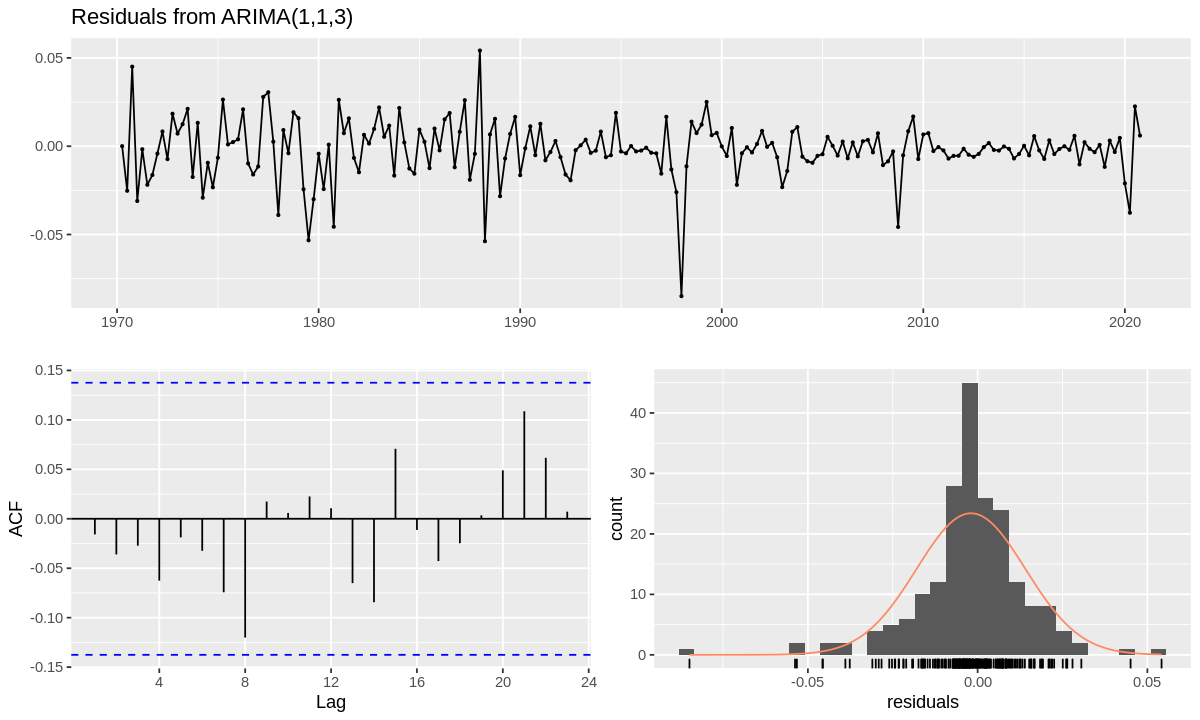

In [33]:
# ARIMA model
arima_model = auto.arima(diff(log(gdp_sa_ts[,3])))

arima_model = gdp_sa_ts[,3] %>% log() %>% diff() %>% auto.arima()
summary(arima_model)
checkresiduals(arima_model)

Qtr1        Qtr2        Qtr3        Qtr4       
2021 0.010917529 0.006615572 0.006697264 0.006679172

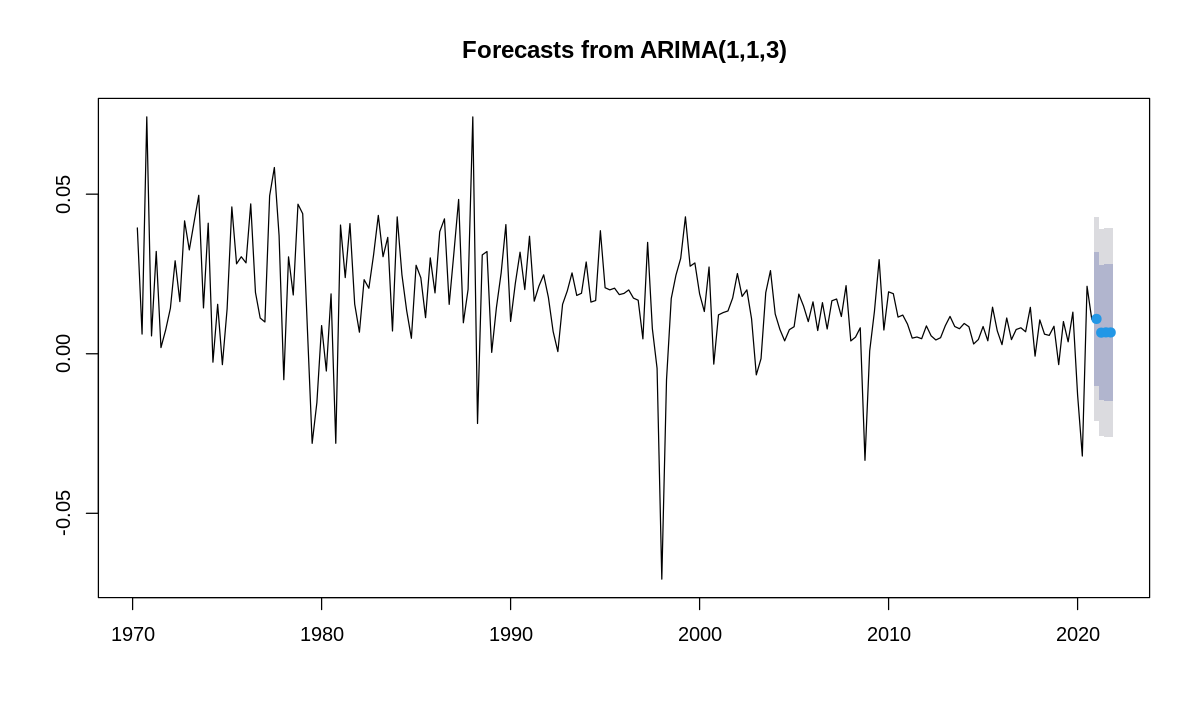

In [34]:
ff = forecast(arima_model, h=4) %>% plot()
ff$mean %>% tail()

## 7. GDP의 분해

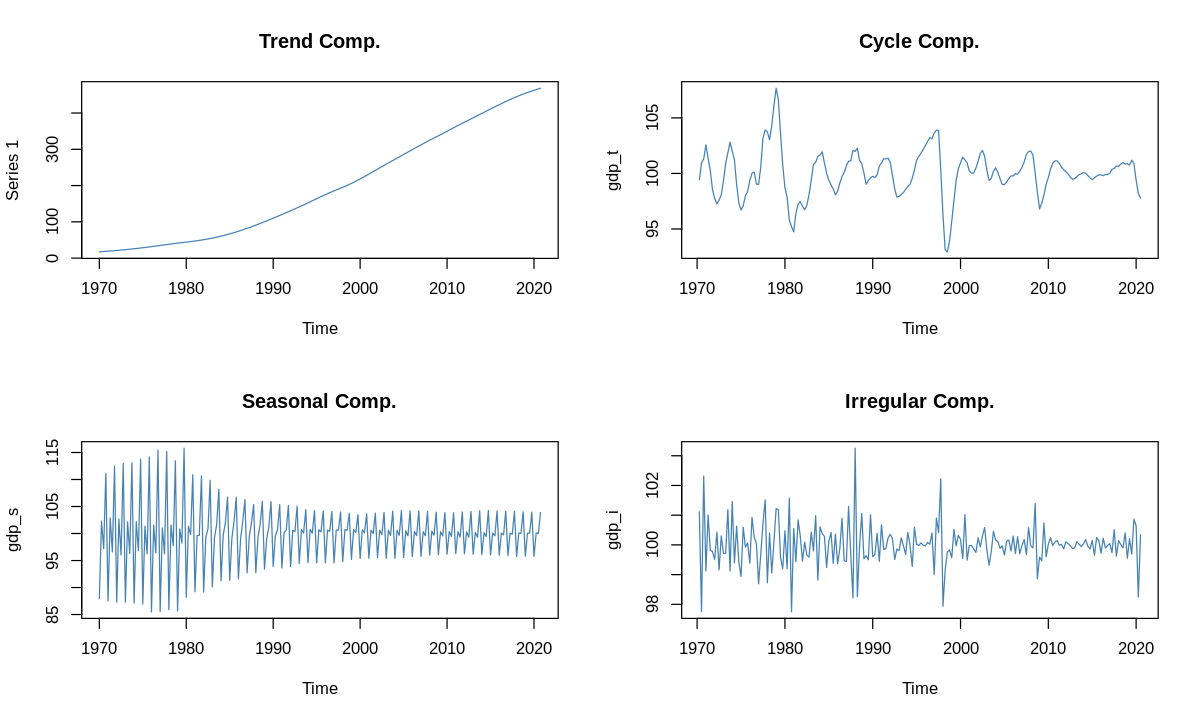

In [36]:
# GDP 변동요인 분해 
 lgdp.hp = mFilter(log(gdp_sa),filter="HP")   # Hodrick-Prescott filter
 gdp_t = exp(lgdp.hp$trend)
 gdpsam = exp((log(gdp_sa)+lag(log(gdp_sa),-1)+lag(log(gdp_sa),1))/3)
 gdp_s = gdp/gdp_sa*100
 gdp_i = gdp_sa/gdpsam*100
 gdp_c = gdpsam/gdp_t*100

 
## Fig 5-2 ##
par(mfrow=c(2,2))
plot(gdp_t, main="Trend Comp.", col="steelblue")
plot(gdp_c, main="Cycle Comp.", col="steelblue")
plot(gdp_s, main="Seasonal Comp.", col="steelblue")
plot(gdp_i, main="Irregular Comp.", col="steelblue")